In [1]:
import os
import numpy as np
import cv2
import sys
import pickle
from typing import Callable, List, Tuple
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../'))

from tools.camera import undistort_image
from tools.image_utils import (
    grayscale,
    mask_with_region_of_interest,
    get_canny_pixels,
    gaussian_blur,
    extract_saturation_channel,
    sobel_thresholding
)
from tools.misc import show_images_in_columns
from tools.camera import undistort_image, get_camera_calibration, get_perspective_transform
import matplotlib.cm as cm


In [2]:
PROJECT_ROOT_DIR = '/home/jon/PycharmProjects/self-driving/CarND_Advanced_Lane_Lines_P2'

CALIBRATION_FILE_PATH = os.path.join(PROJECT_ROOT_DIR, 'resources', 'camera_calibration.pkl')
TEST_IMAGES_DIR = os.path.join(PROJECT_ROOT_DIR, 'test_images', 'raw')
WRITE_IMAGES_DIR = os.path.join(PROJECT_ROOT_DIR, 'test_images', 'arial_pixel_highlighting')

IMAGE_FORMAT = 'BGR'

VERTICES_FN: Callable[[np.ndarray], List[Tuple[int, int]]] = lambda image: [
    (0, image.shape[0]),
    (image.shape[1] // 2, 0),
    (image.shape[1], image.shape[0])
]
    

In [3]:
with open(CALIBRATION_FILE_PATH, 'rb') as f:
    ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints, calibration_points = pickle.load(f)

In [7]:
reference_image_fp = os.path.join(TEST_IMAGES_DIR, os.listdir(TEST_IMAGES_DIR)[0])
ref_image = plt.imread(reference_image_fp)

undistorted_image = undistort_image(ref_image, camera_matrix=mtx, distortion_matrix=dist)

# M, Minv, gray_img_shape = get_perspective_transform(undistorted_image, ref_image, x_proportion_bottom=0.5 / 10, x_proportion_top=4 / 10)

In [5]:

def threshIt(img, thresh_min, thresh_max):
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return xbinary
    
def undistortAndHLS(image, mtx=mtx, dist=dist):
    """
    Undistort the image with `mtx`, `dist` and convert it to HLS.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return threshIt(scaled, thresh_min, thresh_max)

withSobelX = lambda img: absSobelThresh(useSChannel(img), thresh_min=10, thresh_max=160)

withSobelY = lambda img: absSobelThresh(useSChannel(img), orient='y', thresh_min=10, thresh_max=160)

useSChannel = lambda img: undistortAndHLS(img)[:,:,2]

def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = withSobelX(img)
    sobelY = withSobelY(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

def select_rgb_white_yellow(image, format_ = 'RGB'): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    if format_ == 'RGB':
        lower = np.uint8([150, 150,   50])
        upper = np.uint8([255, 255, 115])
    elif format_ == 'BGR':
        lower = np.uint8([50, 150, 150])
        upper = np.uint8([115, 255, 255])
    else:
        raise ValueError("Invalid format: {}".format(format_))
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked


def detect_edges_and_get_arial_view(image: np.ndarray, mtx: np.ndarray, dist: np.ndarray, M, gray_img_shape, vertices, image_format):
    undistorted_image = undistort_image(image, camera_matrix=mtx, distortion_matrix=dist)
    binary_combined =  combineGradients(undistorted_image)
    return binary_combined
#     saturation_channel = extract_saturation_channel(undistorted_image, format_=image_format)
    
#     hls = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2HLS)
#     binary_yellow_white = grayscale(select_rgb_white_yellow(undistorted_image), format_ = image_format)
#     binary_saturation_channel = sobel_thresholding(
#         saturation_channel,
#         x_thresh_min=20,
#         y_thresh_max=50,
#         kernel_size=5,
#         direction_thresh_min=0.9,
#         direction_thresh_max=1.3,
#     )

#     thresholded_yellow_white_channel = sobel_thresholding(
#         binary_yellow_white,
#         x_thresh_min=20,
#         y_thresh_max=50,
#         kernel_size=5,
#         direction_thresh_min=0.9,
#         direction_thresh_max=1.3,
#     )

#     binary_combined = np.bitwise_or(binary_saturation_channel, thresholded_yellow_white_channel)
#     arial_image = cv2.warpPerspective(binary_combined, M, gray_img_shape)
# 
#     return arial_image


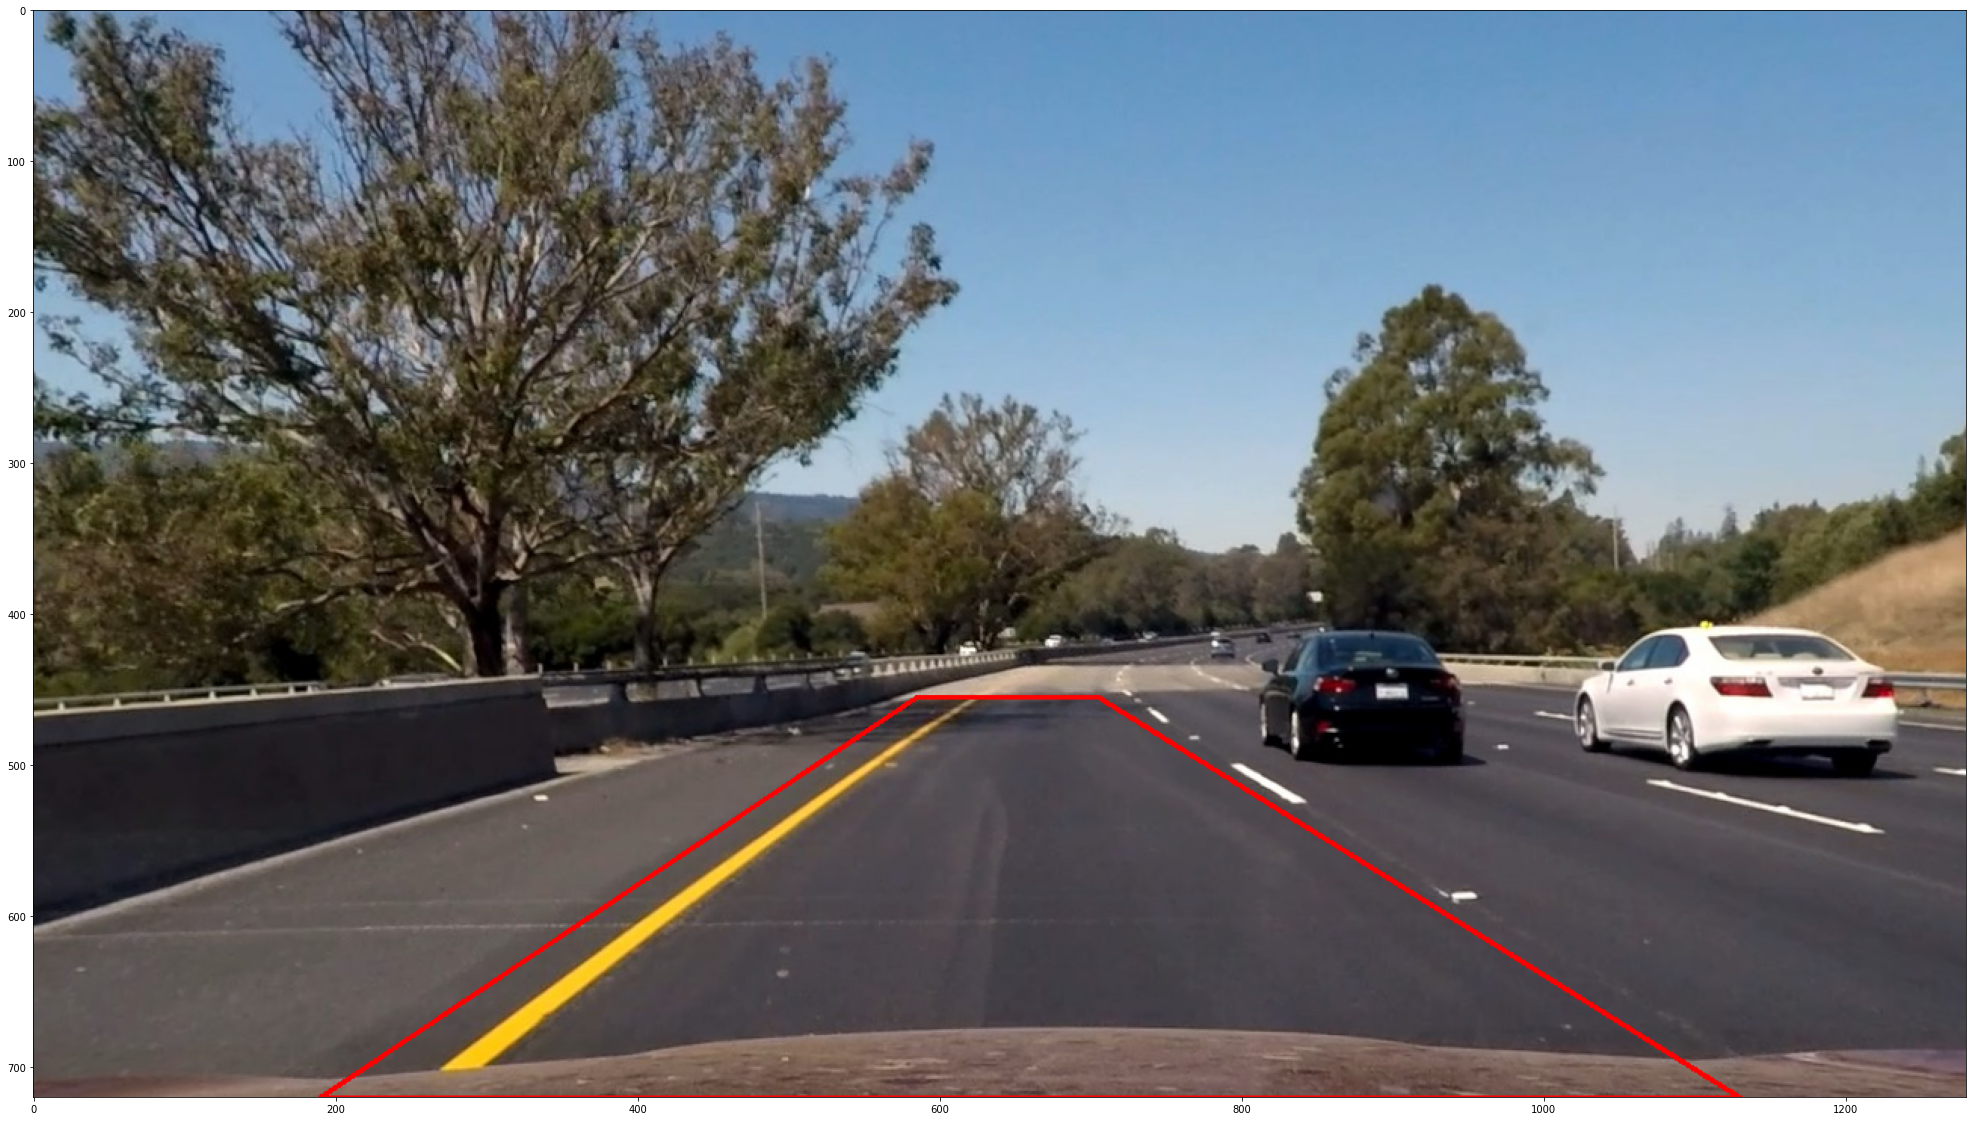

In [10]:
def get_arial_perspective_transformation(undist):
    xSize, ySize, _ = undist.shape
    copy = undist.copy()

    bottomY = 720
    topY = 455


    left1 = (190, bottomY)
    left1_x, left1_y = left1
    left2 = (585, topY)
    left2_x, left2_y = left2

    right1 = (705, topY)
    right1_x, right1_y = right1

    right2 = (1130, bottomY)
    right2_x, right2_y = right2

    color = [255, 0, 0]
    w = 2
    cv2.line(copy, left1, left2, color, w)
    cv2.line(copy, left2, right1, color, w)
    cv2.line(copy, right1, right2, color, w)
    cv2.line(copy, right2, left1, color, w)
    fig, ax = plt.subplots(figsize=(40, 20))
    ax.imshow(copy)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    src = np.float32([ 
        [left2_x, left2_y],
        [right1_x, right1_y],
        [right2_x, right2_y],
        [left1_x, left1_y]
    ])
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    offset = 200
    dst = np.float32([
        [offset, 0],
        [img_size[0]-offset, 0],
        [img_size[0]-offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    img_size = (gray.shape[1], gray.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv
    
    
M, Minv = get_arial_perspective_transformation(undistorted_image)

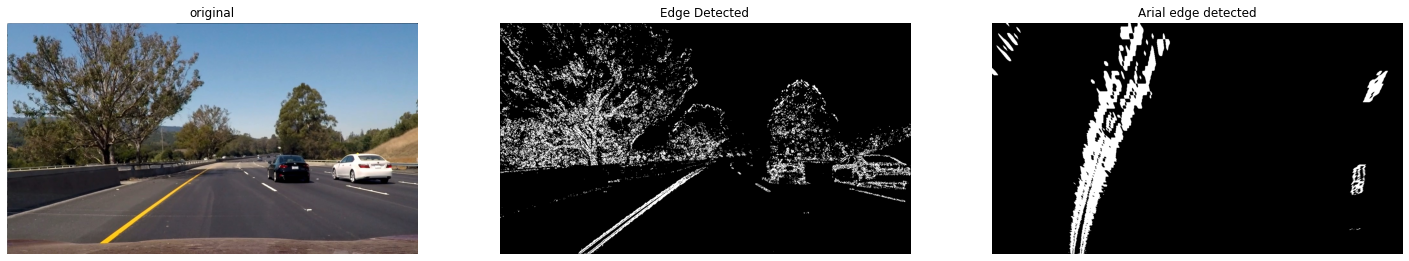

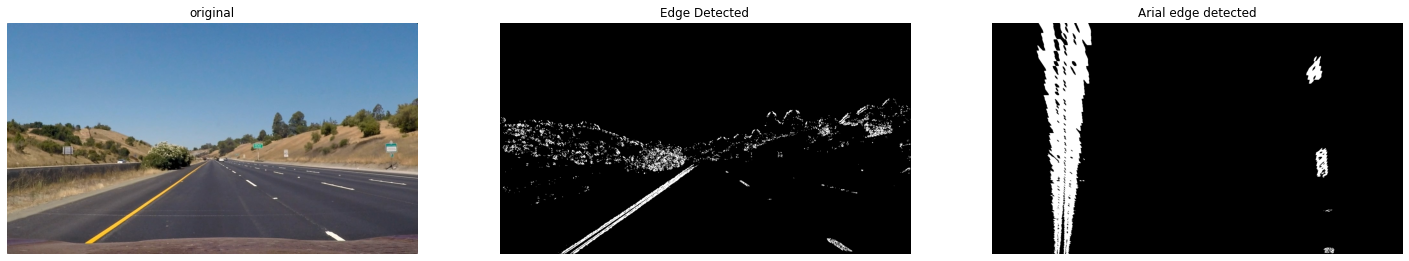

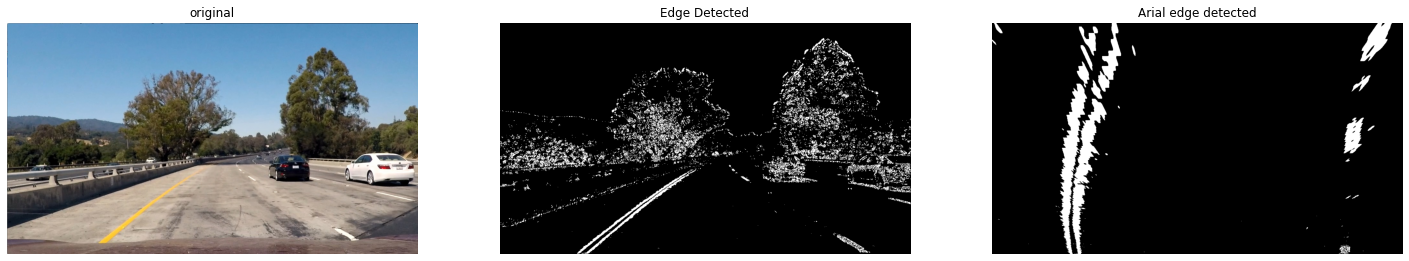

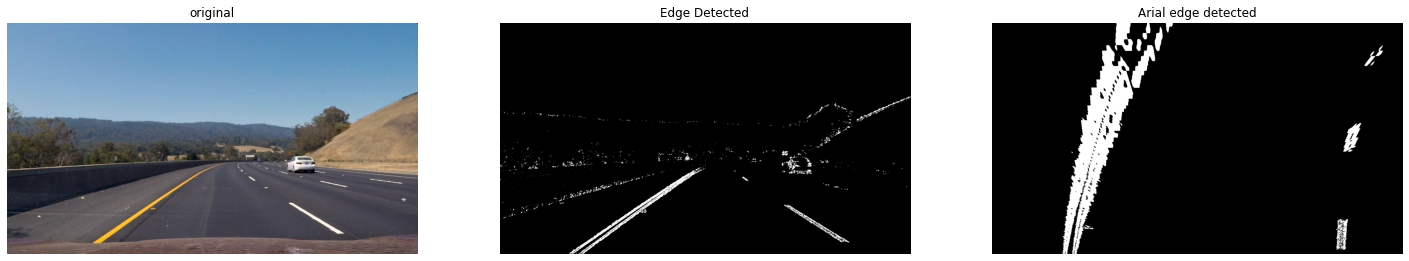

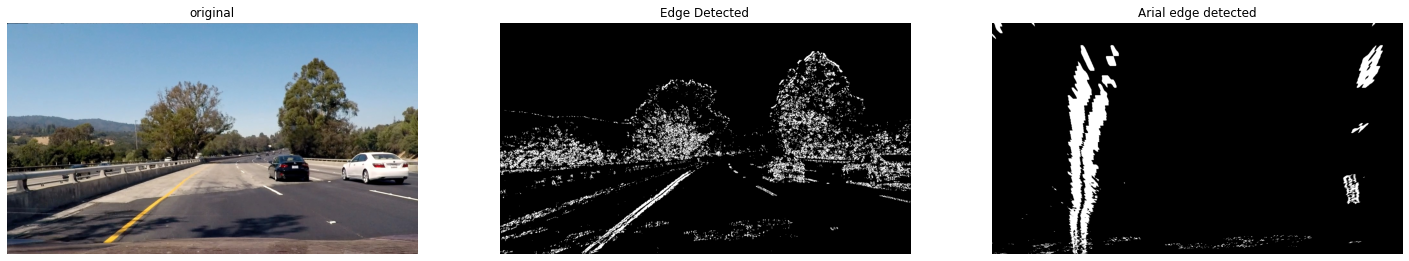

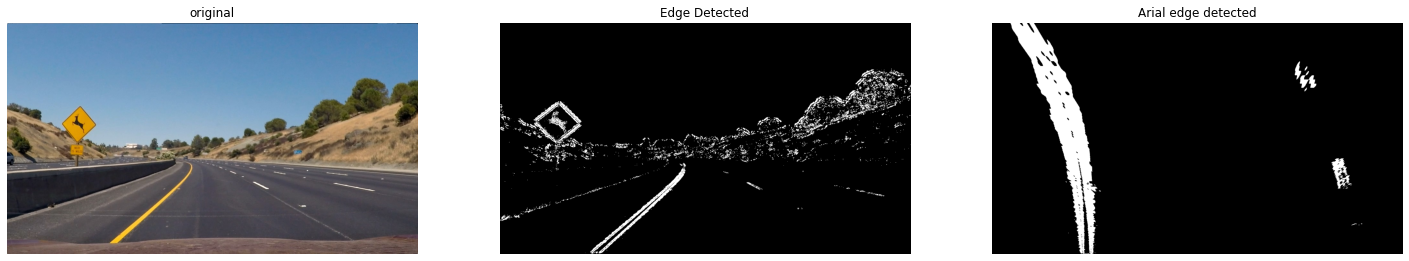

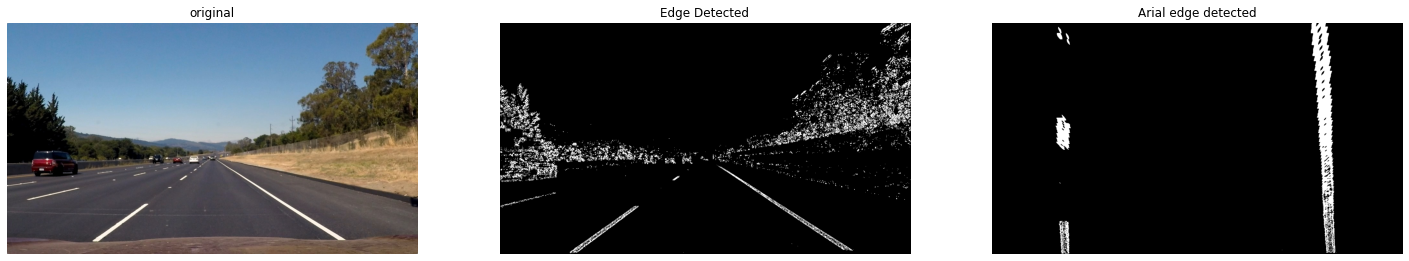

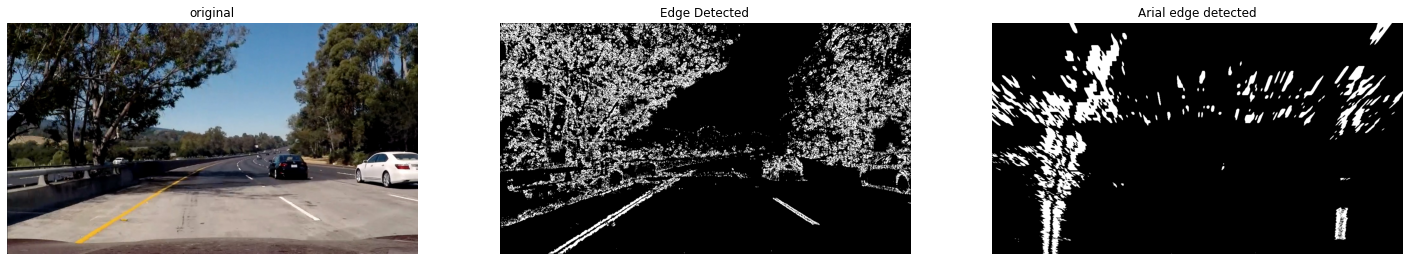

In [12]:
    
for image_name in os.listdir(TEST_IMAGES_DIR):
    image_path = os.path.join(TEST_IMAGES_DIR, image_name)
    image = plt.imread(image_path)
    masked_binary_combined_channel = detect_edges_and_get_arial_view(
        image,
        mtx,
        dist,
        M,
        gray_img_shape,
        VERTICES_FN(image),
        image_format=IMAGE_FORMAT
    )
    
    arial_image = cv2.warpPerspective(masked_binary_combined_channel, M, gray_img_shape)

    show_images_in_columns(
        [image, masked_binary_combined_channel, arial_image],
        ["original", "Edge Detected", "Arial edge detected"],
        [None, 'gray', 'gray']
    )
    plt.imsave(os.path.join(WRITE_IMAGES_DIR, image_name), arial_image, cmap=cm.gray)
    
